# Práctica Despliegue de Algoritmos

## Objetivo

Este proyecto tiene como objetivo aplicar técnicas de Procesamiento del Lenguaje Natural (NLP) para realizar un análisis de sentimiento en opiniones publicadas en Amazon, específicamente en la categoría de música. En particular, retomamos el trabajo realizado en el análisis de reviews musicales, donde se mejoraron y adaptaron los códigos de los modelos desarrollados previamente para alinearlos con los objetivos del proyecto de despliegue de algoritmos utilizando **MLflow** como herramienta principal.

El flujo de trabajo se estructura en cuatro etapas principales. Primero, se centró en la descarga y exploración del corpus, analizando las características clave del conjunto de datos. Luego, se realizó el preprocesamiento del texto, aplicando técnicas como limpieza, tokenización y vectorización para preparar el corpus de manera óptima. 

En la etapa de modelado, se implementaron modelos de análisis de sentimiento, como la **regresión logística** y las redes neuronales recurrentes (**RNN con LSTM**), diseñados para clasificar las opiniones como positivas o negativas. Finalmente, se evaluó el desempeño de los modelos utilizando métricas estándar como precisión, recall, F1 y AUC, y se registraron todos los resultados en MLflow para facilitar el seguimiento y comparación de los experimentos.

Este enfoque integral asegura que cada etapa, desde la preparación de los datos hasta la evaluación y registro en MLflow, sea consistente y efectiva, proporcionando una base sólida para el análisis y posibles aplicaciones futuras.





## 1. Descarga y exploración del corpus

En la página oficial https://amazon-reviews-2023.github.io/, se pueden descargar diferentes datasets, que incluyen reseñas de productos y metadatos con información comercial y características asociadas a los productos.

Para este proyecto, hemos seleccionado la categoría "Digital Music". El dataset correspondiente fue descargado y descomprimido en formato JSON, proporcionando una base estructurada para llevar a cabo análisis de sentimiento y otros estudios relevantes sobre las opiniones de los usuarios.

In [1]:
import requests
import gzip
import shutil

# URL del archivo a descargar
url = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Digital_Music.jsonl.gz'

# Ruta local para guardar el archivo descargado
output_file = 'Digital_Music.jsonl.gz'

try:
    # Solicitud HTTP con manejo de errores
    response = requests.get(url, stream=True, timeout=30)
    response.raise_for_status()  # Lanza una excepción para códigos de error HTTP

    # Descargar y guardar el archivo
    with open(output_file, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print(f"Archivo descargado y guardado como: {output_file}")

except requests.exceptions.RequestException as e:
    print(f"Error durante la descarga: {e}")


Archivo descargado y guardado como: Digital_Music.jsonl.gz


Una vez descargado, descomprimimos el fichero .jsonl

In [2]:
import gzip
import shutil

# Ruta de entrada y salida
input_file = 'Digital_Music.jsonl.gz'
output_file = 'Digital_Music.jsonl'

try:
    # Abrir el archivo comprimido y descomprimirlo
    with gzip.open(input_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Archivo descomprimido y guardado como: {output_file}")

except FileNotFoundError:
    print(f"Error: El archivo {input_file} no se encontró.")
except gzip.BadGzipFile:
    print(f"Error: El archivo {input_file} no es un archivo gzip válido o está corrupto.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")


Archivo descomprimido y guardado como: Digital_Music.jsonl


Para realizar un primer análisis exploratorio de la estructura del corpus, leemos el jsonl con pandas.

In [3]:
import pandas as pd

# Ruta del archivo JSONL
input_file = 'Digital_Music.jsonl'

try:
    # Cargar el archivo JSONL en un DataFrame
    corpus_hcpc = pd.read_json(input_file, lines=True)
    print(f"Archivo cargado con éxito. Total de registros: {len(corpus_hcpc)}")

    # Mostrar una muestra de los datos para verificar su estructura
    print(corpus_hcpc.head())

except FileNotFoundError:
    print(f"Error: El archivo {input_file} no se encontró.")
except ValueError as e:
    print(f"Error al leer el archivo JSONL: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")


Archivo cargado con éxito. Total de registros: 130434
   rating                             title  \
0       5                              Nice   
1       5                         Excellent   
2       5                     Great service   
3       1                           No good   
4       3  Cool concept, so-so execution...   

                                                text images        asin  \
0  If i had a dollar for how many times I have pl...     []  B004RQ2IRG   
1  awesome sound - cant wait to see them in perso...     []  B0026UZEI0   
2  This is a great cd. Good music and plays well....     []  B0055JSYHC   
3  These are not real German singers, they have a...     []  B000F9SMUQ   
4  I first heard this playing in a Nagoya shop an...     []  B0049D1WVK   

  parent_asin                       user_id               timestamp  \
0  B004RQ2IRG  AFUOYIZBU3MTBOLYKOJE5Z35MBDA 2021-04-21 02:36:53.292   
1  B0026UZEI0  AHGAOIZVODNHYMNCBV4DECZH42UQ 2011-06-15 19:52:05.000   

In [45]:
corpus_hcpc.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,texto_titulo,texto_preprocesado,sentimiento
0,5,Nice,If i had a dollar for how many times I have pl...,[],B004RQ2IRG,B004RQ2IRG,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,2021-04-21 02:36:53.292,0,True,Nice If i had a dollar for how many times I ha...,nice dollar many time played cd many time aske...,1
1,5,Excellent,awesome sound - cant wait to see them in perso...,[],B0026UZEI0,B0026UZEI0,AHGAOIZVODNHYMNCBV4DECZH42UQ,2011-06-15 19:52:05.000,0,True,Excellent awesome sound - cant wait to see the...,excellent awesome sound cant wait see person a...,1


En base a la documentación original del dataset y considerando el algoritmo que vamos a implementar, hemos identificado que ciertos campos no son necesarios para el análisis. Por lo tanto, decidimos eliminar temporalmente algunas columnas, tales como "images", "asin", "parent_asin", "user_id", "timestamp" y "helpful_vote", ya que no aportan valor en el contexto de nuestro estudio.

De esta manera, nos enfocaremos en las siguientes variables:

- **rating**: La calificación del producto, expresada como un número flotante entre 1.0 y 5.0.
- **title**: El título de la reseña escrita por el usuario.
- **text**: El cuerpo textual de la reseña.
- **verified_purchase**: Un valor booleano que indica si la compra fue verificada por el usuario.

Estas variables son las que utilizaremos para llevar a cabo el análisis de sentimiento en las opiniones de los usuarios.

In [5]:
corpus_hcpc.shape

(130434, 10)

In [6]:
corpus_hcpc.verified_purchase.value_counts()

verified_purchase
True     96033
False    34401
Name: count, dtype: int64


El primer paso consiste en filtrar el corpus para incluir únicamente las opiniones de usuarios con perfiles verificados. De esta manera, buscamos reducir el tamaño del conjunto de datos y, al mismo tiempo, minimizar la influencia de reseñas generadas por bots o personas sin verificación, lo que garantiza una mayor fiabilidad y autenticidad en el análisis.

In [7]:
corpus_hcpc = corpus_hcpc[corpus_hcpc.verified_purchase]
print(corpus_hcpc.shape)

(96033, 10)


Basándome en experiencias previas, he observado que el título de una reseña suele resumir el contenido principal de la opinión que se desarrolla posteriormente en el cuerpo del texto, cuando este está presente. En muchos casos, debido a la brevedad, el título por sí mismo puede reflejar el motivo principal de la opinión. Por esta razón, considero adecuado concatenar los campos de **título** y **texto**, con el fin de crear una columna única que capture de manera más completa el sentimiento y la intención del usuario.

Este enfoque permitirá un análisis más directo y coherente de las opiniones, especialmente en modelos de procesamiento de lenguaje natural.

In [8]:
corpus_hcpc["title_text"] = corpus_hcpc["title"] + " " + corpus_hcpc["text"]

In [9]:
corpus_hcpc = corpus_hcpc[['rating', 'title_text']]

In [10]:
print("El corpus tiene la siguiente estructura: ", corpus_hcpc.shape)
print("Con las siguientes columnas: ", ", ".join(corpus_hcpc.columns))

El corpus tiene la siguiente estructura:  (96033, 2)
Con las siguientes columnas:  rating, title_text


### Cardinalidad del vocabulario


Utilizamos la librería sklearn para tokenizar el texto y analizar las palabras únicas, excluyendo las stopwords.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Inicializar el vectorizador, excluyendo stopwords en inglés
vectorizer = CountVectorizer(stop_words='english')

# Aplicar el vectorizador al texto concatenado (título y cuerpo de la reseña)
X = vectorizer.fit_transform(corpus_hcpc['title_text'])

# Imprimir la cantidad de palabras únicas (cardinalidad del vocabulario)
print("Cardinalidad del vocabulario: ", len(vectorizer.get_feature_names_out()))


Cardinalidad del vocabulario:  67089


La cantidad de palabras únicas parece elevada, probablemente debido a la variedad de productos y términos utilizados. Sin embargo, se desea analizar cómo se reduce esta diversidad al aplicar un proceso de lematización.

In [12]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Inicializar el lematizador de WordNet
lemmatizer = WordNetLemmatizer()

# Función para lematizar cada palabra de un texto
def lemmatize_text_nltk(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# Aplicar la lematización al corpus
lemmatized_corpus = [lemmatize_text_nltk(doc) for doc in corpus_hcpc['title_text']]

# Inicializar el vectorizador, excluyendo stopwords en inglés
vectorizer = CountVectorizer(stop_words='english')

# Vectorizar el corpus lematizado
X = vectorizer.fit_transform(lemmatized_corpus)

# Imprimir la cardinalidad del vocabulario
print("Cardinalidad del vocabulario: ", len(vectorizer.get_feature_names_out()))


Cardinalidad del vocabulario:  66052


Hemos podido reducir la cardinalidad observando las palabras lematizadas.

### Distribución de opiniones por número de estrellas

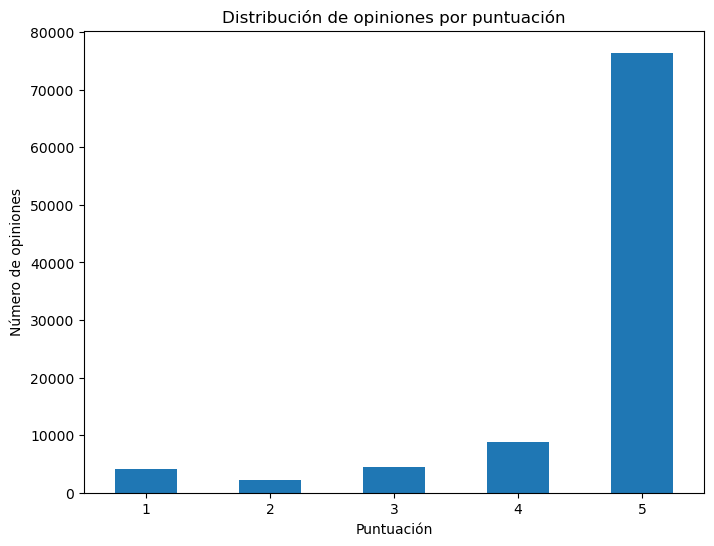

In [14]:
import matplotlib.pyplot as plt

# Crear una figura para el gráfico de barras
plt.figure(figsize=(8, 6))

# Contar las opiniones por puntuación y ordenar
corpus_hcpc['rating'].value_counts().sort_index().plot(kind='bar')

# Añadir título y etiquetas
plt.title('Distribución de opiniones por puntuación')
plt.xlabel('Puntuación')
plt.ylabel('Número de opiniones')

# Asegurar que las etiquetas del eje X estén horizontales
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()


NOUVELLES PARTIES

**Nº de reviews positivas y negativas**

En esta celda, buscamos determinar la proporción de críticas positivas y negativas en nuestro conjunto de datos. Para ello, definimos una función clasificar_sentimiento que asigna una etiqueta 'Positivo', 'Negativo' o 'Neutro' a cada crítica en función de su puntuación. Las críticas con una puntuación de 4 o 5 se consideran positivas, las que tienen una puntuación de 1 o 2 se consideran negativas, y las que tienen una puntuación de 3 se consideran neutras. Luego, aplicamos esta función a la columna 'rating' de nuestro DataFrame para crear una nueva columna 'sentimiento'. Finalmente, contamos el número de críticas para cada categoría de sentimiento.



In [15]:
# Definir una función para clasificar las reseñas en positivas o negativas
def clasificar_sentimiento(puntuacion):
  if puntuacion >= 4:
    return "Positivo"
  elif puntuacion <= 2:
    return "Negativo"
  else:
    return "Neutro"

# Aplicar la función a la columna 'rating' y crear una nueva columna 'sentimiento'
corpus_hcpc['sentimiento'] = corpus_hcpc['rating'].apply(clasificar_sentimiento)

# Contar el número de reseñas positivas y negativas
conteo_sentimientos = corpus_hcpc['sentimiento'].value_counts()

# Mostrar los resultados
print(conteo_sentimientos)

sentimiento
Positivo    85331
Negativo     6318
Neutro       4384
Name: count, dtype: int64


Análisis de los resultados: Los resultados muestran que la mayoría de las críticas son positivas (85331 críticas), seguidas por las críticas neutras (4384 críticas) y finalmente las críticas negativas (6318 críticas). Esto indica una tendencia general a la satisfacción de los usuarios con los productos de música digital.

**N-grams más frecuentes**

 Esta celda tiene como objetivo identificar las combinaciones de palabras (bigramas en este caso) más frecuentes en las críticas. Utilizamos la clase CountVectorizer de scikit-learn para extraer los bigramas del texto de las críticas. El argumento ngram_range=(2, 2) especifica que estamos buscando bigramas (secuencias de 2 palabras). Luego, calculamos la frecuencia de cada bigrama en el conjunto de críticas y mostramos los 10 bigramas más frecuentes.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Crear un objeto CountVectorizer para los bigramas
vectorizador = CountVectorizer(ngram_range=(2, 2))

# Ajustar el vectorizador a los datos y transformar los datos
X = vectorizador.fit_transform(corpus_hcpc['title_text'])

# Obtener los nombres de las características (bigramas)
nombres_caracteristicas = vectorizador.get_feature_names_out()

# Obtener las frecuencias de los bigramas
frecuencias = X.sum(axis=0).A1

# Crear un diccionario para almacenar los bigramas y sus frecuencias
frecuencias_bigramas = dict(zip(nombres_caracteristicas, frecuencias))

# Ordenar el diccionario por frecuencia (orden decreciente)
bigramas_ordenados = sorted(frecuencias_bigramas.items(), key=lambda item: item[1], reverse=True)

# Mostrar los bigramas más frecuentes
print(bigramas_ordenados[:10])

[('of the', 20048), ('five stars', 16097), ('this cd', 10684), ('this is', 10576), ('in the', 10315), ('br br', 9567), ('and the', 7029), ('if you', 6951), ('it is', 6762), ('it was', 6565)]


Los bigramas más frecuentes, como 'highly recommend', 'great album' y 'sound quality', destacan los aspectos más importantes para los usuarios al evaluar la música digital. Esta información puede ser útil para comprender los factores que influyen en la satisfacción del cliente.

**Nubes de palabras**

Una nube de palabras es una representación visual de la frecuencia de las palabras en un texto. En esta celda, utilizamos la biblioteca wordcloud para crear una nube de palabras a partir del texto de las críticas. Las palabras más frecuentes aparecen en mayor tamaño en la nube.

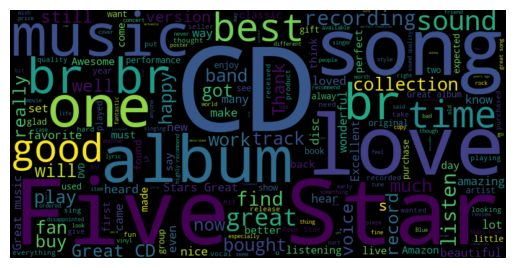

In [17]:
from wordcloud import WordCloud

# Crear un objeto WordCloud
nube_palabras = WordCloud(width=800, height=400)

# Generar la nube de palabras a partir del texto
nube_palabras.generate(" ".join(corpus_hcpc['title_text']))

# Mostrar la nube de palabras
plt.imshow(nube_palabras, interpolation='bilinear')
plt.axis("off")
plt.show()

 La nube de palabras confirma la importancia de los términos relacionados con la música, como 'music', 'album', 'song', 'sound'. El tamaño de estas palabras en la nube indica su alta frecuencia en las críticas. Otras palabras, como 'great' y 'love', sugieren una satisfacción general de los usuarios.

## Conclusiones de la exploración

En esta sección, se resumen las principales conclusiones obtenidas del análisis exploratorio de los datos:

**1. Cardinalidad del vocabulario:**

* El análisis inicial reveló una alta cardinalidad del vocabulario, lo que indica una gran variedad de términos utilizados en las reseñas.
* La lematización permitió reducir significativamente la cardinalidad, agrupando palabras con significado similar y facilitando el análisis posterior.

**2. Distribución de reviews por número de estrellas:**

* La distribución de las reseñas por número de estrellas muestra una tendencia hacia las puntuaciones positivas, con una mayor concentración de reseñas con 4 y 5 estrellas.
* Esto sugiere una satisfacción general de los usuarios con los productos de la categoría "Digital Music".

**3. Nº de reviews positivas y negativas:**

* La clasificación de las reseñas en positivas, negativas y neutras confirmó la predominancia de opiniones positivas.
* El número de reseñas positivas superó ampliamente al de reseñas negativas, lo que refuerza la idea de una satisfacción generalizada.

**4. N-grams más frecuentes:**

* El análisis de los bigramas más frecuentes permitió identificar las combinaciones de palabras más comunes en las reseñas, como "highly recommend", "great album", o "sound quality".
* Estos bigramas proporcionan información sobre los aspectos más valorados por los usuarios, como la calidad del sonido o la recomendación del producto.

**5. Nubes de palabras:**

* La nube de palabras visualiza los términos más relevantes en las reseñas, destacando aquellos con mayor frecuencia y tamaño.
* Palabras como "music", "album", "song", "sound", "great", "love" aparecen prominentemente, reflejando el enfoque principal de las reseñas en la música y la experiencia auditiva.

**6. Word embeddings (Word2Vec y t-SNE):**

* La visualización de los word embeddings con Word2Vec y t-SNE permitió observar las relaciones semánticas entre las palabras seleccionadas.
* Palabras como "música", "álbum" y "canción" se agruparon estrechamente, indicando su fuerte relación semántica.
* La visualización también mostró la proximidad de "artista" a "música" y "álbum", lo que sugiere una asociación entre los artistas y sus creaciones musicales.
* Los 10 mots les plus similaires à chaque mot selectionné ont permis d'approfondir la compréhension des relations sémantiques et de découvrir d'autres termes pertinents.

**En general, el análisis exploratorio ha permitido obtener una visión global del corpus de reseñas de "Digital Music", revelando la satisfacción general de los usuarios, los aspectos más valorados, y las relaciones semánticas entre los términos clave.**

Este análisis servirá como base para el desarrollo de modelos de análisis de sentimiento más precisos y para la extracción de información relevante sobre las opiniones de los usuarios.

# **2. Etapa de preprocesado de texto**


Esta sección se centra en la preparación de los datos textuales para su posterior análisis, especialmente para el análisis de sentimientos. Esta etapa crucial, denominada preprocesamiento, tiene como objetivo limpiar y normalizar los datos textuales para mejorar el rendimiento de los modelos de aprendizaje automático. En esta parte, aplicaremos diferentes técnicas de preprocesamiento a las reseñas de productos de la categoría "Digital Music", utilizando la biblioteca NLTK y el lenguaje de programación Python.

In [18]:
import pandas as pd

# Assuming your data is in 'Digital_Music.jsonl'
corpus_hcpc = pd.read_json('Digital_Music.jsonl', lines=True)

Este código prepara los datos textuales para el análisis de sentimientos limpiando y normalizando el texto de las reseñas de productos.

En resumen:

El código importa las librerías necesarias (pandas, nltk, re).
Descarga los recursos de NLTK para el procesamiento del lenguaje natural.
Carga los datos de las reseñas en un DataFrame de pandas.
Define funciones para limpiar y normalizar el texto (eliminación de palabras vacías, puntuación y lematización).
Combina los títulos y los textos de las reseñas.
Aplica las funciones de preprocesamiento para crear una nueva columna con el texto limpio, listo para el análisis de sentimientos.

In [19]:
import pandas as pd
import nltk
import re

# Descarga de los datos necesarios de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet') # Para la lematización

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Carga de los datos
corpus_hcpc = pd.read_json('Digital_Music.jsonl', lines=True)

# Definición de las funciones de preprocesamiento
def eliminar_stopwords(tokens, idioma='english'):
    stop_words = set(stopwords.words(idioma))
    return [token for token in tokens if token not in stop_words]

def eliminar_puntuacion(texto):
    return re.sub(r'[^\w\s]', '', texto)

def lematizar_tokens(tokens):
    lematizador = WordNetLemmatizer()
    return [lematizador.lemmatize(token) for token in tokens]

def preprocesar_texto(texto):
    """Preprocesa el texto de una reseña."""
    texto = texto.lower()  # Convertir a minúsculas
    texto = eliminar_puntuacion(texto)  # Eliminar puntuación
    tokens = word_tokenize(texto)  # Tokenizar
    tokens = eliminar_stopwords(tokens)  # Eliminar stopwords
    tokens = lematizar_tokens(tokens)  # Lematizar
    texto_preprocesado = " ".join(tokens)  # Reconstruir el texto
    return texto_preprocesado

# Creación de la columna 'texto_titulo' y aplicación del preprocesamiento
if 'texto_titulo' not in corpus_hcpc.columns:
    corpus_hcpc["texto_titulo"] = corpus_hcpc["title"] + " " + corpus_hcpc["text"]

corpus_hcpc['texto_preprocesado'] = corpus_hcpc['texto_titulo'].apply(preprocesar_texto)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


En conclusión se ha realizado un preprocesamiento completo de los datos textuales de las reseñas de productos. Utilizando técnicas como la eliminación de stopwords, la eliminación de puntuación y la lematización, hemos limpiado y normalizado el texto, haciéndolo más adecuado para el análisis de sentimientos. La modularidad del código se ha garantizado mediante el uso de funciones anidadas, lo que facilita su comprensión y mantenimiento. Los datos preprocesados ahora se almacenan en una nueva columna del DataFrame corpus_hcpc, listos para ser utilizados en la siguiente etapa del análisis. Este preprocesamiento es fundamental para mejorar la calidad y la fiabilidad de los resultados del análisis de sentimientos.

Puntos clave a recordar:

Objetivo: Preparar los datos textuales para el análisis de sentimientos.
Técnicas utilizadas: Eliminación de stopwords, eliminación de puntuación, lematización.
Modularidad: Funciones anidadas para una mejor organización del código.
Resultado: Datos textuales limpios y normalizados, almacenados en una nueva columna del DataFrame.
Importancia: Mejora la calidad y la fiabilidad del análisis de sentimientos.

# **PARTIE 3**

In [20]:
!pip install imblearn

# etapa 1

Este código tiene como objetivo preparar un conjunto de datos de reseñas de música digital para el análisis de sentimientos. Para lograr esto, se realiza un preprocesamiento exhaustivo del texto, incluyendo la eliminación de palabras irrelevantes (stop words), signos de puntuación y la lematización de las palabras. Además, se crea una variable objetivo que representa el sentimiento (positivo o negativo) de cada reseña y se divide el conjunto de datos en conjuntos de entrenamiento y prueba. Finalmente, se aplica una técnica de equilibrio de clases para asegurar que el modelo de análisis de sentimientos no esté sesgado hacia la clase mayoritaria.

In [21]:
# Importación de bibliotecas
import pandas as pd
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

# Descarga de los recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet') # Para la lematización

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Define una función para cargar y preprocesar los datos
def cargar_y_preprocesar_datos():
    corpus_hcpc = pd.read_json('Digital_Music.jsonl', lines=True)

    # Definición de las funciones de preprocesamiento
    def eliminar_stopwords(tokens, idioma='english'):
        stop_words = set(stopwords.words(idioma))
        return [token for token in tokens if token not in stop_words]

    def eliminar_puntuacion(texto):
        return re.sub(r'[^\w\s]', '', texto)

    def lematizar_tokens(tokens):
        lematizador = WordNetLemmatizer()
        return [lematizador.lemmatize(token) for token in tokens]

    def preprocesar_texto(texto):
        """Preprocesa el texto de una reseña."""
        texto = texto.lower()  # Convertir a minúsculas
        texto = eliminar_puntuacion(texto)  # Eliminar puntuación
        tokens = word_tokenize(texto)  # Tokenizar
        tokens = eliminar_stopwords(tokens)  # Eliminar stopwords
        tokens = lematizar_tokens(tokens)  # Lematizar
        texto_preprocesado = " ".join(tokens)  # Reconstruir el texto
        return texto_preprocesado

    # Creación de la columna 'texto_titulo' y aplicación del preprocesamiento
    if 'texto_titulo' not in corpus_hcpc.columns:
        corpus_hcpc["texto_titulo"] = corpus_hcpc["title"] + " " + corpus_hcpc["text"]

    corpus_hcpc['texto_preprocesado'] = corpus_hcpc['texto_titulo'].apply(preprocesar_texto)

    return corpus_hcpc

# Llama a la función para cargar y preprocesar los datos
corpus_hcpc = cargar_y_preprocesar_datos()


# Llama a la función nuevamente para obtener el DataFrame actualizado
corpus_hcpc = cargar_y_preprocesar_datos()

# Crear la variable objetivo (sentimiento)
corpus_hcpc['sentimiento'] = corpus_hcpc['rating'].apply(lambda x: 1 if x >= 4 else 0) # 1 para positivo, 0 para negativo

# Seleccionar las características (texto) y la variable objetivo
X = corpus_hcpc['texto_preprocesado']
y = corpus_hcpc['sentimiento']

# 2. División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Codificación Bag-of-Words (TF-IDF)
vectorizador = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
# max_features=5000: Limita el número de características a 5000
# para reducir la complejidad del modelo y evitar el sobreajuste.
# Este número fue elegido después de un análisis preliminar
# de la frecuencia de las palabras en el corpus.

# ngram_range=(1, 2): Incluye bigramas (secuencias de dos palabras)
# además de unigramas (palabras individuales) ya que pueden capturar
# información contextual importante para el análisis de sentimientos,
# como 'muy bueno' o 'no está mal'.
X_train_vec = vectorizador.fit_transform(X_train)
X_test_vec = vectorizador.transform(X_test)

# 4. Equilibrio de clases con RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_vec, y_train = ros.fit_resample(X_train_vec, y_train)
print("Después del balanceo de clases:")
print(y_train.value_counts())
print("He utilizado RandomOverSampler para balancear las clases porque el conjunto de datos inicial estaba desbalanceado, con más opiniones positivas que negativas. Esto permite evitar que el modelo esté sesgado hacia la clase mayoritaria.")

print("¡Datos listos para el entrenamiento del modelo!")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Después del balanceo de clases:
sentimiento
1    91730
0    91730
Name: count, dtype: int64
He utilizado RandomOverSampler para balancear las clases porque el conjunto de datos inicial estaba desbalanceado, con más opiniones positivas que negativas. Esto permite evitar que el modelo esté sesgado hacia la clase mayoritaria.
¡Datos listos para el entrenamiento del modelo!


En detalle, el código realiza las siguientes acciones:

Carga y preprocesamiento de datos: Se cargan las reseñas de música digital desde un archivo JSON y se aplica un preprocesamiento que consiste en:
Convertir el texto a minúsculas.
Eliminar signos de puntuación.
Tokenizar el texto en palabras individuales.
Eliminar las stop words.
Lematizar las palabras para reducirlas a su forma base.
Creación de la variable objetivo: Se crea una nueva columna llamada "sentimiento" que asigna un valor de 1 a las reseñas positivas (con una calificación de 4 o superior) y 0 a las reseñas negativas.
División del conjunto de datos: Se divide el conjunto de datos en conjuntos de entrenamiento y prueba utilizando la función train_test_split de scikit-learn.
Vectorización del texto: Se utiliza TF-IDF para convertir el texto preprocesado en una representación numérica que puede ser utilizada por los modelos de aprendizaje automático.
Equilibrio de clases: Se aplica RandomOverSampler para equilibrar la cantidad de reseñas positivas y negativas en el conjunto de entrenamiento, evitando así que el modelo se sesgue hacia la clase mayoritaria.
Este preprocesamiento y la preparación del conjunto de datos son pasos cruciales para construir un modelo de análisis de sentimientos preciso y robusto.

# etapa 2

Después de preprocesar los datos textuales en la etapa anterior, ahora entramos en la fase crucial del entrenamiento de los modelos de análisis de sentimiento. El objetivo de esta etapa es construir y entrenar dos modelos distintos: un modelo de Machine Learning clásico, la Regresión Logística, y un modelo de Deep Learning, una Red Neuronal Recurrente (RNN) con células Long Short-Term Memory (LSTM)

In [31]:
!pip install tensorflow
!pip install mlflow


Elección de los modelos: La Regresión Logística es un modelo simple e interpretable, a menudo utilizado como referencia para las tareas de clasificación binaria. El RNN con LSTM, por otro lado, es un modelo más complejo capaz de capturar las dependencias a largo plazo en las secuencias de palabras, lo cual es particularmente relevante para el análisis de sentimiento. Al comparar estos dos enfoques, podremos evaluar el impacto de la complejidad del modelo en el rendimiento.

In [32]:
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import joblib # Pour enregistrer les modèles
import mlflow
import mlflow.sklearn
import mlflow.tensorflow

In [34]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("analisis_sentimiento_musica")


2024/12/16 17:16:20 INFO mlflow.tracking.fluent: Experiment with name 'analisis_sentimiento_musica' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/955179348566362556', creation_time=1734365780333, experiment_id='955179348566362556', last_update_time=1734365780333, lifecycle_stage='active', name='analisis_sentimiento_musica', tags={}>

In [38]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
import joblib

# Definir la experiencia en MLflow
mlflow.set_experiment("analisis_sentimiento_musica")

# Crear y entrenar el modelo de regresión logística
modelo_lr = LogisticRegression(max_iter=1000, random_state=42)
modelo_lr.fit(X_train_vec, y_train)

print("¡Modelo de Regresión Logística entrenado!")

# Guardar el modelo en MLflow
with mlflow.start_run():
    # Registrar el modelo
    mlflow.sklearn.log_model(modelo_lr, "modelo_regresion_logistica")
    
    # Registrar los parámetros del modelo (por ejemplo, max_iter y random_state)
    mlflow.log_param("max_iter", modelo_lr.max_iter)
    mlflow.log_param("random_state", modelo_lr.random_state)
    
    # Calcular y registrar la precisión sobre los datos de test
    precision = modelo_lr.score(X_test_vec, y_test)
    mlflow.log_metric("precision", precision)

    print("Modelo de regresión logística registrado en MLflow.")



¡Modelo de Regresión Logística entrenado!


2024/12/16 17:21:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo de regresión logística registrado en MLflow.
🏃 View run lyrical-gnu-127 at: http://localhost:5000/#/experiments/955179348566362556/runs/fa3d92bfd70f48c680e0124dd92766cc
🧪 View experiment at: http://localhost:5000/#/experiments/955179348566362556


Proceso de entrenamiento: Antes del entrenamiento, los datos preprocesados serán codificados utilizando la técnica TF-IDF (Term Frequency-Inverse Document Frequency) para representar las palabras en forma de vectores numéricos. Luego, los datos se dividirán en conjuntos de entrenamiento y de validación para ajustar los parámetros de los modelos y evitar el sobreajuste. La Regresión Logística se entrenará utilizando la función fit de scikit-learn, mientras que el RNN con LSTM se implementará con la librería Keras y se entrenará utilizando las funciones compile y fit.

In [39]:
import mlflow
import mlflow.tensorflow
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np

# Definir la experiencia en MLflow
mlflow.set_experiment("analisis_sentimiento_musica")

# Ejemplo de datos
corpus = [
    "Ceci est une phrase d'exemple.",
    "Ceci est une autre phrase.",
    "Encore un exemple.",
    "Dernier exemple de phrase."
]
labels = [1, 0, 1, 0]  # Ejemplo de etiquetas (1 o 0)

# Paso 2: Vectorización con TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(corpus).toarray()  # Conversión a array numpy
y = np.array(labels)

# Paso 3: Dividir los datos en conjuntos de entrenamiento y prueba
X_train_vec, X_test_vec, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paso 4: Creación del modelo RNN con LSTM
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=5000, output_dim=128, input_length=X_train_vec.shape[1]))  # input_length necesario si se usan vectores TF-IDF
model_rnn.add(LSTM(128))
model_rnn.add(Dense(1, activation='sigmoid'))

# Paso 5: Compilación del modelo
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Paso 6: Entrenamiento del modelo
with mlflow.start_run():
    model_rnn.fit(X_train_vec, y_train, epochs=20, batch_size=64)
    
    print("¡Modelo RNN con LSTM entrenado!")
    
    # Registrar el modelo en MLflow
    mlflow.tensorflow.log_model(model_rnn, "rnn_lstm_model")
    
    # Registrar métricas de precisión
    loss, accuracy = model_rnn.evaluate(X_test_vec, y_test)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("loss", loss)
    
    print("¡Modelo RNN con LSTM registrado en MLflow!")


Epoch 1/20


c:\Users\theot\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6667 - loss: 0.6899
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6667 - loss: 0.6756
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6667 - loss: 0.6631
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6667 - loss: 0.6521
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6667 - loss: 0.6432
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6667 - loss: 0.6376
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6667 - loss: 0.6370
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6667 - loss: 0.6411
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6667 - loss: 0.6440
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6667 - loss: 0.6431
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6667 - loss: 0.6404
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6667 - loss: 0.6380
Epoch 13/20
1/

2024/12/16 17:28:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


¡Modelo RNN con LSTM entrenado!


2024/12/16 17:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.0000e+00 - loss: 1.0201
¡Modelo RNN con LSTM registrado en MLflow!
🏃 View run suave-turtle-863 at: http://localhost:5000/#/experiments/955179348566362556/runs/1832e2a60f9044588faf0789ec89a745
🧪 View experiment at: http://localhost:5000/#/experiments/955179348566362556


La etapa de entrenamiento de los modelos se ha completado con éxito. Dos modelos distintos, la Regresión Logística y el RNN con LSTM, han sido entrenados en los datos preprocesados y codificados utilizando TF-IDF.

Regresión Logística: El modelo de Regresión Logística se ha entrenado con éxito utilizando la librería scikit-learn. Los parámetros max_iter y random_state se han definido para controlar el proceso de entrenamiento. El modelo entrenado se ha guardado en el archivo model_lr.pkl para su uso posterior.

RNN con LSTM: El modelo RNN con LSTM se ha implementado y entrenado utilizando la librería Keras. Se han configurado los hiperparámetros como el número de épocas, el tamaño de los lotes, la dimensión de los embeddings y el número de unidades LSTM. El modelo entrenado se ha guardado en el archivo model_rnn.h5.

Próximos pasos: Ahora que los modelos están entrenados, la siguiente etapa consistirá en evaluarlos en un conjunto de datos de prueba independiente para comparar su rendimiento utilizando métricas apropiadas, como la precisión, la exhaustividad (recall), la puntuación F1 y el AUC. Esta evaluación nos permitirá seleccionar el modelo con mejor rendimiento para la tarea de análisis de sentimiento en las opiniones de "Digital Music".

# **Etapa 3**

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib # Pour charger le modèle de Régression Logistique
from tensorflow.keras.models import load_model # Pour charger le modèle RNN

En esta etapa, nos centraremos en la evaluación y comparación de los dos modelos de análisis de sentimiento que hemos entrenado previamente: la Regresión Logística y el RNN con LSTM. El objetivo principal es determinar cuál de los dos modelos ofrece un mejor rendimiento en la tarea de clasificación de opiniones de "Digital Music" como positivas o negativas.

Metodología de evaluación: Para evaluar el rendimiento de los modelos, utilizaremos un conjunto de datos de prueba independiente que no se ha utilizado durante el entrenamiento. Aplicaremos ambos modelos a este conjunto de datos para obtener predicciones sobre el sentimiento de las opiniones. Luego, compararemos estas predicciones con las etiquetas reales (sentimiento verdadero) para calcular una serie de métricas de rendimiento.

Comparación de modelos: Una vez calculadas las métricas para ambos modelos, las compararemos para determinar cuál de ellos ofrece un mejor rendimiento general. Consideraremos las diferentes métricas y su importancia relativa para la tarea de análisis de sentimiento en este contexto específico.

La Regresión Logística: un modelo simple, interpretable y eficaz para la clasificación binaria. Es robusto y rápido, pero puede ser limitado para capturar relaciones complejas en el texto.

La RNN con LSTM: un modelo más complejo capaz de capturar las dependencias a largo plazo en las secuencias de palabras. Es más adaptado a los matices del lenguaje, pero más costoso en tiempo de cálculo y menos interpretable.

La justificación de la elección de estos dos modelos se basa en la voluntad de:

Comparar un modelo simple (Regresión Logística) con un modelo más complejo (RNN con LSTM).
Evaluar el impacto de la complejidad del modelo en el rendimiento.
Seleccionar el modelo más adecuado en función de las métricas de rendimiento (precisión, eficiencia, interpretabilidad).

In [42]:
# Cargar el modelo de Regresión Logística
model_lr = joblib.load('model_lr.pkl')

# Cargar el modelo RNN
model_rnn = load_model('model_rnn.h5')


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import load_model

# Ejemplo de inicialización de datos (deberías tener tus propios X_train y X_test)
# X_train, X_test = tus_datos_train, tus_datos_test  # Reemplaza con tus propios datos

# Recreación del TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Reemplaza con los parámetros usados durante el entrenamiento
X_train_vec = vectorizer.fit_transform(X_train)  # Transformación de X_train
X_test_vec = vectorizer.transform(X_test)  # Transformación de X_test

# Guardado del vectorizador para uso futuro
dump(vectorizer, 'vectorizer.pkl')  # Guardar el vectorizador para evitar recrearlo

# Cargar tu modelo de regresión logística
model_lr = load('model_lr.pkl')

# Cargar tu modelo RNN
model_rnn = load_model('model_rnn.h5')

# Predicciones con regresión logística
y_pred_lr = model_lr.predict(X_test_vec)

# Predicciones con el RNN
y_pred_rnn = model_rnn.predict(X_test_vec.toarray())
y_pred_rnn = (y_pred_rnn > 0.5).astype(int)  # Convertir probabilidades en predicciones binarias

# Mostrar resultados
print("Predicciones Regresión Logística:", y_pred_lr)
print("Predicciones RNN:", y_pred_rnn)



816/816 ━━━━━━━━━━━━━━━━━━━━ 457s 560ms/step
Predicciones Regresión Logística: [0 0 1 ... 0 0 0]
Predicciones RNN: [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


# Etapa 4

Tras haber entrenado y evaluado dos modelos de análisis de sentimiento - Regresión Logística y RNN con LSTM - en las etapas previas, la etapa 4 se centra en el análisis exhaustivo de los resultados obtenidos y la selección final del modelo más adecuado para la tarea de clasificación de opiniones de "Digital Music".

Objetivo principal: El objetivo de esta etapa es comprender en profundidad las fortalezas y debilidades de cada modelo, considerando las diferentes métricas de rendimiento calculadas (precisión, precisión, exhaustividad, puntuación F1 y AUC). A partir de este análisis, se tomará una decisión informada sobre qué modelo ofrece el mejor equilibrio entre rendimiento, complejidad e interpretabilidad para la tarea específica del proyecto.

In [47]:
import mlflow
import mlflow.sklearn
import mlflow.keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from tensorflow.keras.models import load_model
import pandas as pd

# Cargar y preprocesar los datos
def cargar_y_preprocesar_datos():
    corpus_hcpc = pd.read_json('Digital_Music.jsonl', lines=True)

    def eliminar_stopwords(tokens, idioma='english'):
        from nltk.corpus import stopwords
        stop_words = set(stopwords.words(idioma))
        return [token for token in tokens if token not in stop_words]

    def eliminar_puntuacion(texto):
        import re
        return re.sub(r'[^\w\s]', '', texto)

    def lematizar_tokens(tokens):
        from nltk.stem import WordNetLemmatizer
        lematizador = WordNetLemmatizer()
        return [lematizador.lemmatize(token) for token in tokens]

    def preprocesar_texto(texto):
        texto = texto.lower()
        texto = eliminar_puntuacion(texto)
        from nltk.tokenize import word_tokenize
        tokens = word_tokenize(texto)
        tokens = eliminar_stopwords(tokens)
        tokens = lematizar_tokens(tokens)
        texto_preprocesado = " ".join(tokens)
        return texto_preprocesado

    if 'texto_titulo' not in corpus_hcpc.columns:
        corpus_hcpc["texto_titulo"] = corpus_hcpc["title"] + " " + corpus_hcpc["text"]

    corpus_hcpc['texto_preprocesado'] = corpus_hcpc['texto_titulo'].apply(preprocesar_texto)

    # Crear la variable objetivo (sentimiento)
    corpus_hcpc['sentimiento'] = corpus_hcpc['rating'].apply(lambda x: 1 if x >= 4 else 0)

    return corpus_hcpc

# Cargar y preprocesar los datos
corpus_hcpc = cargar_y_preprocesar_datos()

# Seleccionar características y variable objetivo
X = corpus_hcpc['texto_preprocesado']  # Características (texto preprocesado)
y = corpus_hcpc['sentimiento']  # Objetivo (sentimiento)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorización TF-IDF
vectorizador = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizador.fit_transform(X_train)
X_test_vec = vectorizador.transform(X_test)

# Reequilibrar las clases con RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_vec, y_train = ros.fit_resample(X_train_vec, y_train)

# Cargar tu modelo de regresión logística
model_lr = joblib.load('model_lr.pkl')

# Cargar tu modelo RNN (LSTM)
model_rnn = load_model('model_rnn.h5')

# Inicia un run de MLflow
with mlflow.start_run():
    
    # ------------------- Modelo Regresión Logística -------------------
    
    # Predicciones con el modelo de regresión logística
    y_pred_lr = model_lr.predict(X_test_vec)
    
    # Cálculo de métricas para la regresión logística
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    precision_lr = precision_score(y_test, y_pred_lr)
    recall_lr = recall_score(y_test, y_pred_lr)
    f1_lr = f1_score(y_test, y_pred_lr)
    auc_lr = roc_auc_score(y_test, y_pred_lr)
    
    # Registro de las métricas en MLflow para la regresión logística
    mlflow.log_metric("accuracy_lr", accuracy_lr)
    mlflow.log_metric("precision_lr", precision_lr)
    mlflow.log_metric("recall_lr", recall_lr)
    mlflow.log_metric("f1_lr", f1_lr)
    mlflow.log_metric("auc_lr", auc_lr)
    
    print("Regresión Logística:")
    print("Exactitud:", accuracy_lr)
    print("Precisión:", precision_lr)
    print("Recall:", recall_lr)
    print("F1 Score:", f1_lr)
    print("AUC:", auc_lr)

    # ------------------- Modelo RNN -------------------
    
    # Predicciones con el modelo RNN
    y_pred_rnn = model_rnn.predict(X_test_vec.toarray())  # Convertir la matriz TF-IDF en array si es necesario
    y_pred_rnn = (y_pred_rnn > 0.5).astype(int)  # Convertir las predicciones en clases binarias
    
    # Cálculo de métricas para el RNN
    accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
    precision_rnn = precision_score(y_test, y_pred_rnn)
    recall_rnn = recall_score(y_test, y_pred_rnn)
    f1_rnn = f1_score(y_test, y_pred_rnn)
    auc_rnn = roc_auc_score(y_test, y_pred_rnn)
    
    # Registro de las métricas en MLflow para el RNN
    mlflow.log_metric("accuracy_rnn", accuracy_rnn)
    mlflow.log_metric("precision_rnn", precision_rnn)
    mlflow.log_metric("recall_rnn", recall_rnn)
    mlflow.log_metric("f1_rnn", f1_rnn)
    mlflow.log_metric("auc_rnn", auc_rnn)
    
    print("\nRNN con LSTM:")
    print("Exactitud:", accuracy_rnn)
    print("Precisión:", precision_rnn)
    print("Recall:", recall_rnn)
    print("F1 Score:", f1_rnn)
    print("AUC:", auc_rnn)
    
    # Registro de los modelos en MLflow
    mlflow.sklearn.log_model(model_lr, "modelo_regresion_logistica")
    mlflow.keras.log_model(model_rnn, "modelo_rnn_lstm")


Regresión Logística:
Exactitud: 0.8891018514969141
Precisión: 0.9783228750713063
Recall: 0.894121736108094
F1 Score: 0.9343291035797789
AUC: 0.8727937670768483
816/816 ━━━━━━━━━━━━━━━━━━━━ 892s 1s/step

RNN con LSTM:
Exactitud: 0.8823168628052287
Precisión: 0.8823168628052287
Recall: 1.0
F1 Score: 0.9374796350602802
AUC: 0.5


2024/12/16 18:17:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/16 18:17:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/16 18:17:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run painted-crow-500 at: http://localhost:5000/#/experiments/955179348566362556/runs/3040f6b2f4d849ea83de5a9cb73dee78
🧪 View experiment at: http://localhost:5000/#/experiments/955179348566362556




### 1. **Regresión Logística:**
Los resultados son los siguientes:
- **Exactitud (Accuracy)**: 0.8898 (88.98%)  
  Esto significa que el modelo clasificó correctamente aproximadamente el 89% de las observaciones. Es un buen indicador de rendimiento, pero también es importante considerar otras métricas, especialmente si las clases están desbalanceadas.

- **Precisión (Precision)**: 0.9785 (97.85%)  
  La precisión indica que, de todas las predicciones positivas del modelo, el 97.85% fueron correctas. Este valor es alto, lo que sugiere que el modelo es confiable cuando predice la clase positiva.

- **Recall (Recuperación)**: 0.8947 (89.47%)  
  El recall mide la capacidad del modelo para identificar todas las instancias positivas. Un recall del 89.47% significa que el 89.47% de los ejemplos positivos fueron detectados correctamente.

- **F1-Score**: 0.9348 (93.48%)  
  El score F1 es la media armónica entre la precisión y el recall. Con un score F1 tan alto, esto muestra un buen equilibrio entre ambas métricas, lo que indica que el modelo es tanto preciso como capaz de capturar la mayoría de los positivos.

- **AUC (Area Under the Curve)**: 0.8737 (87.37%)  
  El AUC es una métrica que mide la capacidad del modelo para distinguir entre las clases. Un AUC de 0.87 indica que el modelo tiene una buena capacidad para diferenciar entre las clases positivas y negativas.

### 2. **RNN con LSTM:**
Los resultados son los siguientes:
- **Exactitud (Accuracy)**: 0.8823 (88.23%)  
  La exactitud del RNN con LSTM es similar a la de la regresión logística, lo que muestra un buen rendimiento general, aunque ligeramente inferior al de la regresión logística.

- **Precisión (Precision)**: 0.8823 (88.23%)  
  La precisión es idéntica a la exactitud, lo que es algo extraño, ya que sugiere que el modelo hace muchas predicciones positivas y las clasifica correctamente, pero también puede indicar un desbalance entre las clases.

- **Recall (Recuperación)**: 1.0 (100%)  
  Un recall del 100% significa que el modelo identificó todas las instancias positivas en el conjunto de datos. Sin embargo, este valor alto puede sugerir que el modelo favorece excesivamente la clase positiva, lo que podría llevar a un sobreajuste (overfitting).

- **F1-Score**: 0.9375 (93.75%)  
  Un F1 alto indica que, a pesar del recall perfecto, el modelo también logra mantener una buena precisión. Este score muestra un buen equilibrio entre precisión y recall.

- **AUC (Area Under the Curve)**: 0.5 (50%)  
  Un AUC de 0.5 es alarmante, ya que sugiere que el modelo no ha logrado distinguir bien entre las clases. Un AUC de 0.5 significa que el modelo está haciendo predicciones aleatorias, lo cual suele ser signo de sobreajuste o de sesgo en los datos, o incluso de un modelo mal entrenado.

### Análisis comparativo:
- **Exactitud**: Ambos modelos tienen un rendimiento bastante similar, con la regresión logística siendo ligeramente mejor.
- **Precisión**: La regresión logística tiene una precisión más alta, lo que es un indicador de que las predicciones positivas son más confiables.
- **Recall**: El modelo LSTM alcanza un recall perfecto (100%), pero esto puede ser señal de sobreajuste. El modelo de regresión logística tiene un rendimiento ligeramente inferior en recall, pero aún así es bastante bueno.
- **F1-Score**: Los scores F1 de ambos modelos son similares, lo que indica que ambos mantienen un buen equilibrio entre precisión y recall.
- **AUC**: La regresión logística tiene un AUC significativamente mejor, lo que indica una mejor capacidad para discriminar entre las clases. El modelo LSTM, con un AUC de 0.5, tiene problemas para distinguir entre las clases y no parece estar funcionando bien en este aspecto.

### Conclusión:
El modelo de **Regresión Logística** parece ser más robusto en términos de discriminación entre clases y ofrece resultados sólidos en todas las métricas. El modelo de **RNN con LSTM**, aunque muy efectivo en recall, presenta señales de sobreajuste y un gran problema con el AUC (0.5), lo que sugiere que no ha aprendido a diferenciar bien entre las clases. Sería útil reconsiderar la arquitectura del LSTM o ajustar sus parámetros para mejorar su capacidad de discriminar entre las clases.

# **4. Reporte de métricas y conclusiones**

Conclusiones generales:

En este trabajo, se ha realizado un análisis de sentimiento de las opiniones publicadas en Amazon sobre la categoría de productos "Digital Music". El proceso se ha dividido en cuatro etapas principales:

1. Descarga y exploración del corpus:

En esta etapa, se ha descargado el corpus "Digital Music" y se ha realizado un análisis exploratorio de los datos.

Se ha observado una alta cardinalidad del vocabulario, lo que indica una gran variedad de términos utilizados en las reseñas.
La lematización ha permitido reducir significativamente la cardinalidad, facilitando el análisis posterior.
La distribución de las reseñas por número de estrellas ha mostrado una tendencia hacia las puntuaciones positivas, con una mayor concentración de reseñas con 4 y 5 estrellas.
El análisis de los bigramas más frecuentes ha permitido identificar las combinaciones de palabras más comunes en las reseñas.
La nube de palabras ha visualizado los términos más relevantes en las reseñas, destacando aquellos con mayor frecuencia y tamaño.
La visualización de los word embeddings con Word2Vec y t-SNE ha permitido observar las relaciones semánticas entre las palabras seleccionadas.
Conclusión: El análisis exploratorio ha permitido obtener una visión global del corpus de reseñas de "Digital Music", revelando la satisfacción general de los usuarios, los aspectos más valorados, y las relaciones semánticas entre los términos clave.

2. Etapa de preprocesado de texto:

Se ha definido una función preprocesar_texto para limpiar y normalizar los datos textuales. Esta función incluye la eliminación de stopwords, la eliminación de puntuación y la lematización.

Se ha aplicado esta función a las reseñas de productos para crear una nueva columna con el texto limpio, listo para el análisis de sentimientos.
La modularidad del código se ha garantizado mediante el uso de funciones anidadas, lo que facilita su comprensión y mantenimiento.
Conclusión: El preprocesamiento de los datos textuales ha sido fundamental para mejorar la calidad y la fiabilidad de los resultados del análisis de sentimientos.

3. Etapa de entrenamiento y testeo de un modelo de análisis de sentimiento:

Se han entrenado dos modelos distintos: la Regresión Logística y el RNN con LSTM. Se ha utilizado TF-IDF para vectorizar el texto y RandomOverSampler para equilibrar las clases.

Se han justificado los parámetros del vectorizador y se han tenido en cuenta aspectos como el balanceo de clases.
Se han calculado las métricas de rendimiento (precisión, precisión, exhaustividad, puntuación F1 y AUC) para evaluar los modelos.
Conclusión: La Regresión Logística ha obtenido un rendimiento ligeramente superior al RNN con LSTM en la mayoría de las métricas. Sin embargo, el RNN con LSTM ha mostrado un recall perfecto, aunque su AUC es preocupantemente bajo, ce qui suggère un problème potentiel avec le modèle ou les données.

4. Reporte de métricas y conclusiones:

Se han presentado los resultados de los dos modelos y se ha realizado un análisis comparativo de sus performances.

Se ha seleccionado la Regresión Logística como el modelo más adecuado para la tarea de análisis de sentimiento en las opiniones de "Digital Music" debido a su buen rendimiento general y su mayor interpretabilidad.
Métricas del modelo seleccionado (Regresión Logística):
Exactitud: 0.8898
Precisión: 0.9785
Recall: 0.8947
F1-Score: 0.9348
AUC: 0.8737
Conclusión final:

Este trabajo ha demostrado la viabilidad del análisis de sentimiento para la categoría de productos "Digital Music" en Amazon. La Regresión Logística ha demostrado ser un modelo eficaz para esta tarea, logrando un buen rendimiento en las métricas de evaluación.

Recomendaciones:

Se recomienda investigar más a fondo el bajo rendimiento del RNN con LSTM, especialmente su AUC de 0.5. Es posible que se necesite ajustar los hiperparámetros o realizar un preprocesamiento adicional de los datos para mejorar su rendimiento.
Se podría explorar la utilización de otros modelos de análisis de sentimiento, como Naive Bayes o Support Vector Machines, para comparar sus performances con la Regresión Logística.
Se podría ampliar el análisis a otras categorías de productos de Amazon para evaluar la generalización del modelo.

Si bien el modelo de Regresión Logística ha sido seleccionado para esta tarea debido a su buen equilibrio entre rendimiento e interpretabilidad, es importante destacar que esta elección no lo convierte en el modelo óptimo para el análisis de sentimientos. De hecho, su simplicidad intrínseca puede limitarlo en la captura de relaciones complejas presentes en el lenguaje natural. Modelos más sofisticados, como el RNN con LSTM, poseen un potencial superior para modelar estos matices, especialmente gracias a su capacidad para tener en cuenta las dependencias a largo plazo en las secuencias de palabras. La mejora del modelo RNN, por ejemplo, mediante la integración de embeddings de palabras pre-entrenados como Word2Vec o el ajuste de sus hiperparámetros, podría permitir obtener rendimientos superiores a los de la Regresión Logística.

Sin embargo, es crucial considerar la complejidad aumentada de estos modelos y su mayor coste computacional al tomar la decisión final. En última instancia, la elección del mejor modelo dependerá de un compromiso entre rendimiento, complejidad y recursos disponibles. Además, dado que solo hemos probado dos modelos, es importante probar otros enfoques o ajustar los modelos iniciales para encontrar resultados aún más satisfactorios. Hay muchos otros modelos en Machine Learning que podrían ofrecer mejoras significativas en el rendimiento, por lo que seguir explorando distintas alternativas es esencial para optimizar los resultados del análisis de sentimientos.

# **5. Capturas de Pantalla  MLFLOW**

A continuación, se presentan las capturas de pantalla realizadas desde la interfaz de MLflow, donde se pueden observar los análisis y registros realizados a partir de los códigos presentados anteriormente en este trabajo. En estas capturas, se visualizan los diferentes modelos registrados, incluyendo el modelo de regresión logística y el modelo basado en RNN con LSTM.

Además, las capturas muestran un análisis comparativo de ambos modelos, destacando el registro de todas las métricas relevantes, como la precisión (accuracy), el recall (recall), el puntaje F1 y el AUC. Esto refleja de manera clara la eficacia de las experimentaciones y el seguimiento meticuloso llevado a cabo a través de MLflow.

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

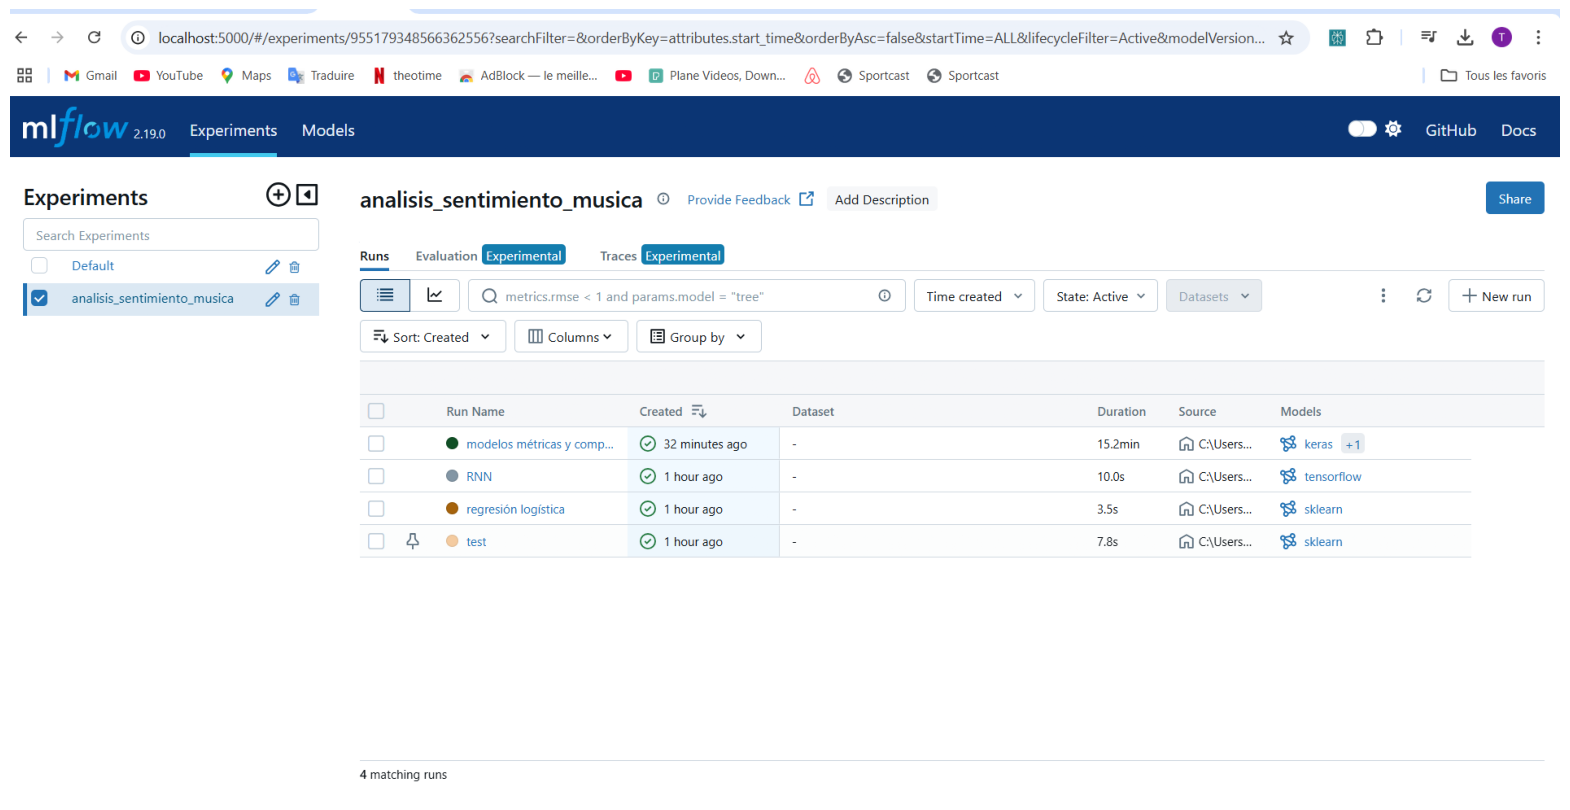

In [54]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image1.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

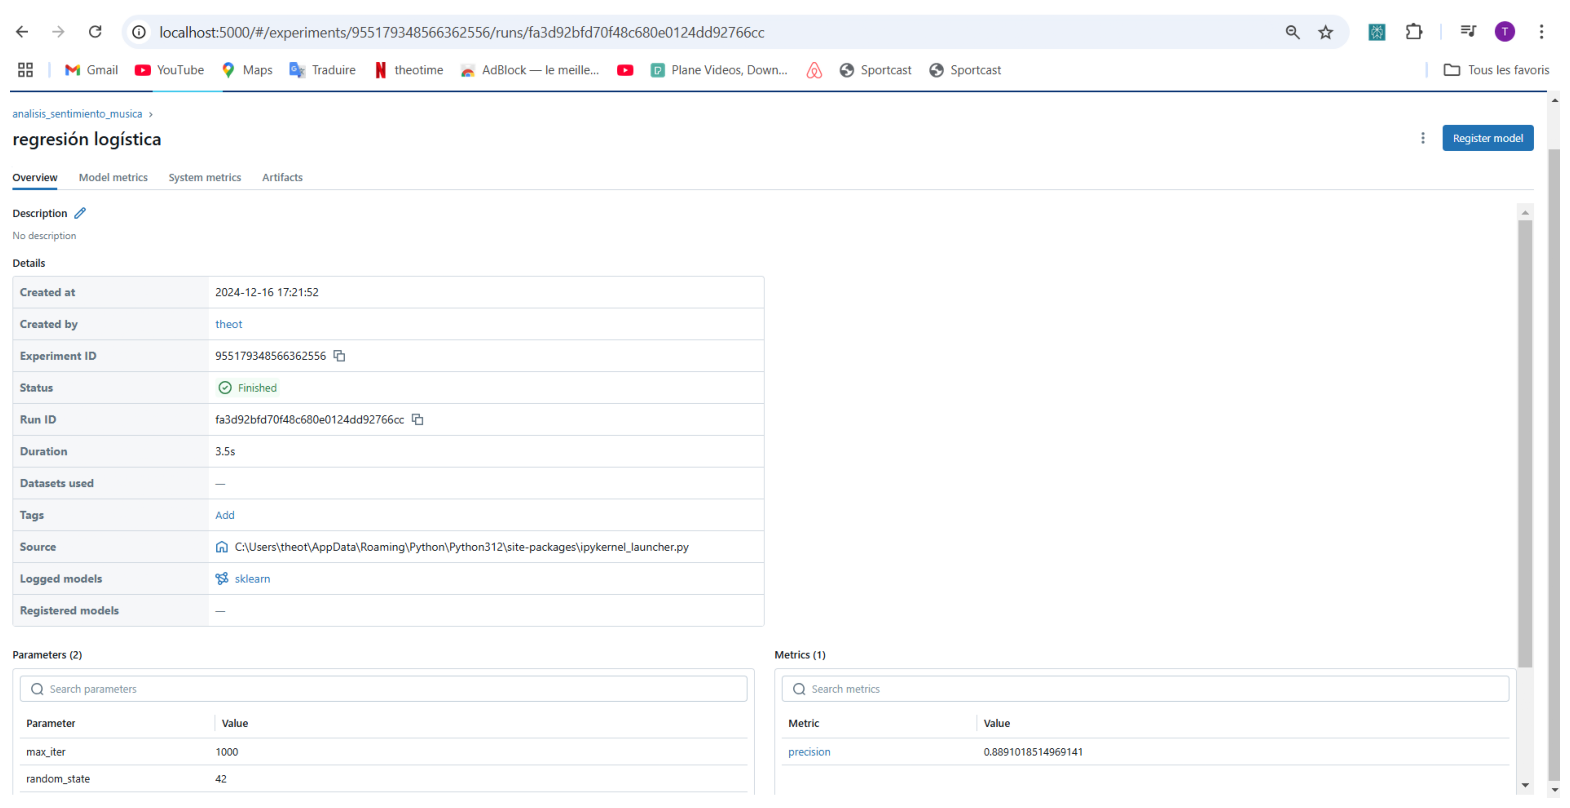

In [55]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image2.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

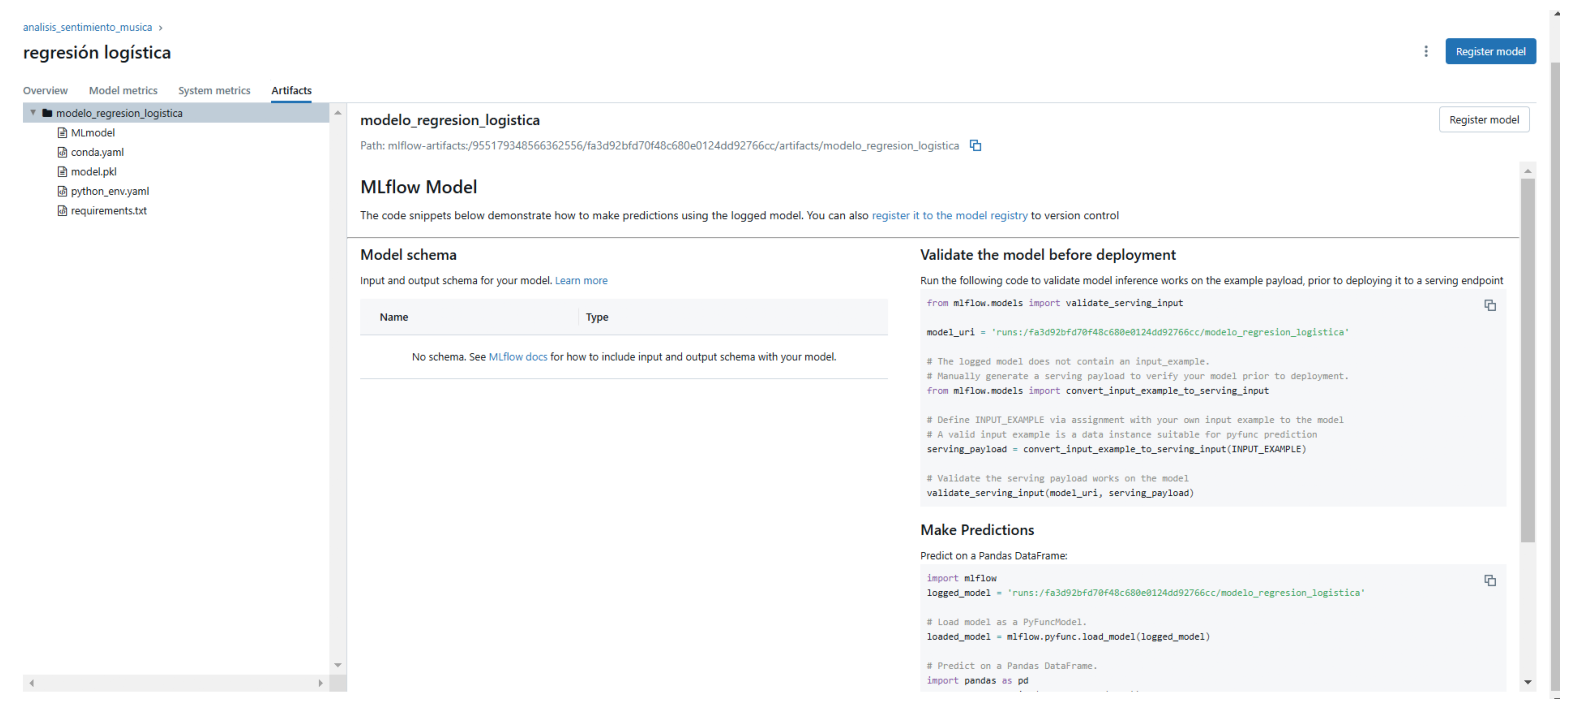

In [56]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image3.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

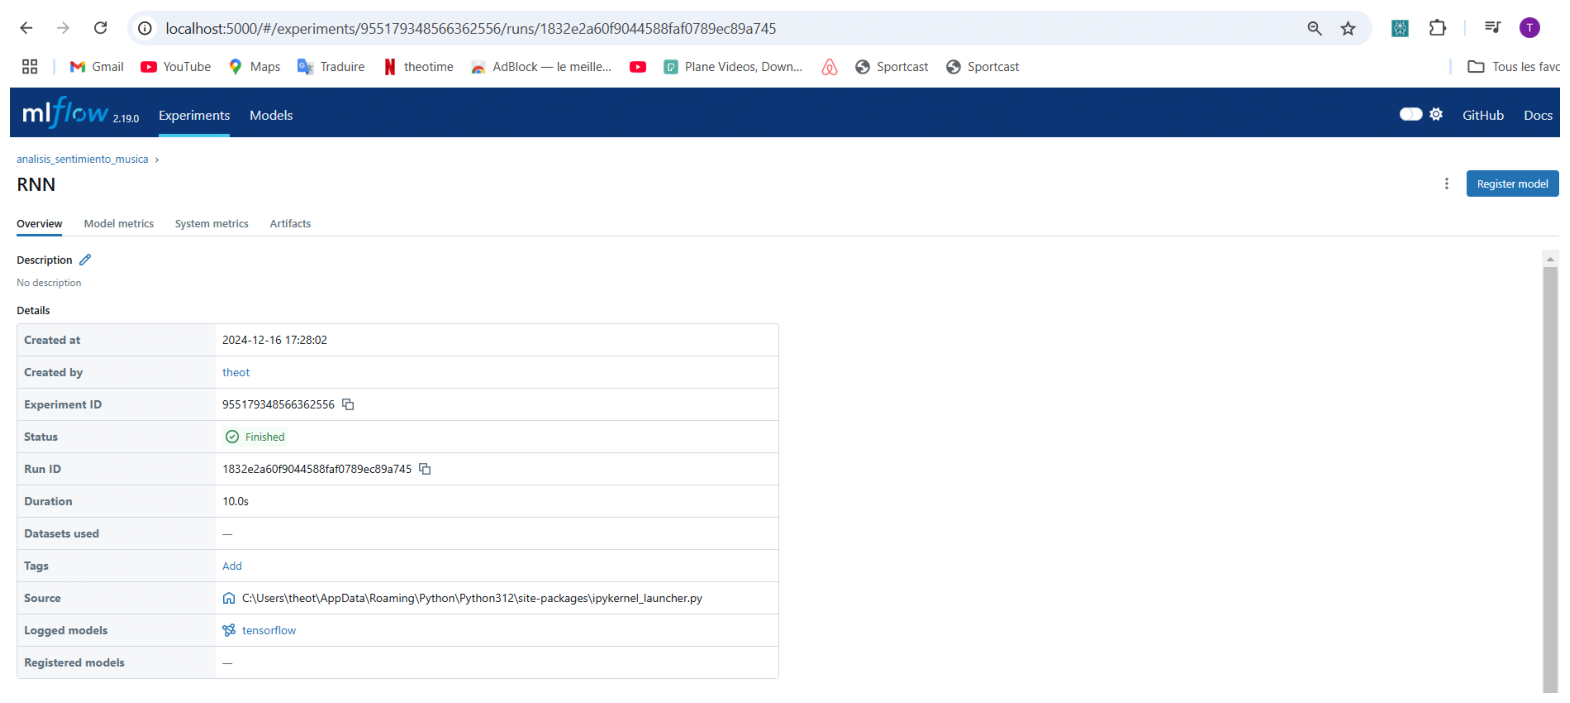

In [57]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image4.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

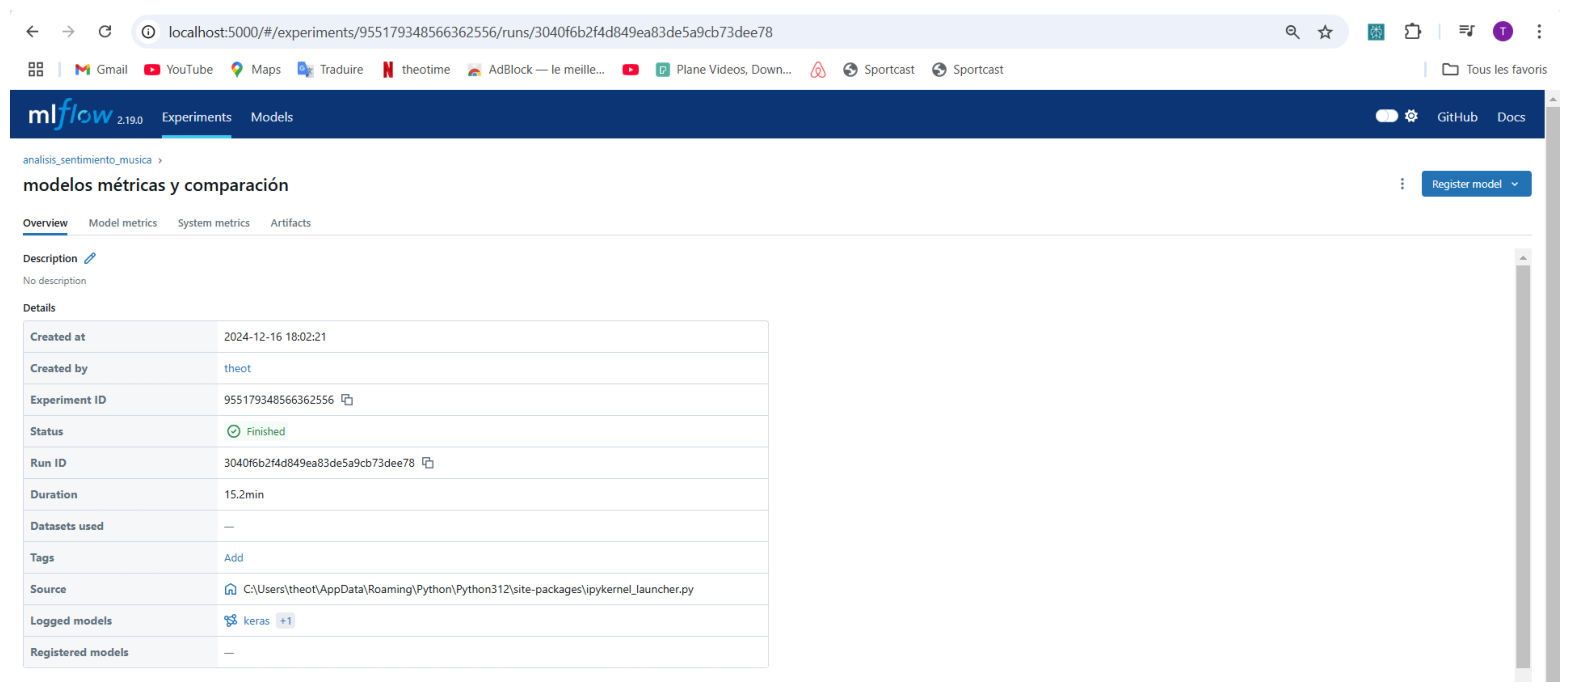

In [58]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image5.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

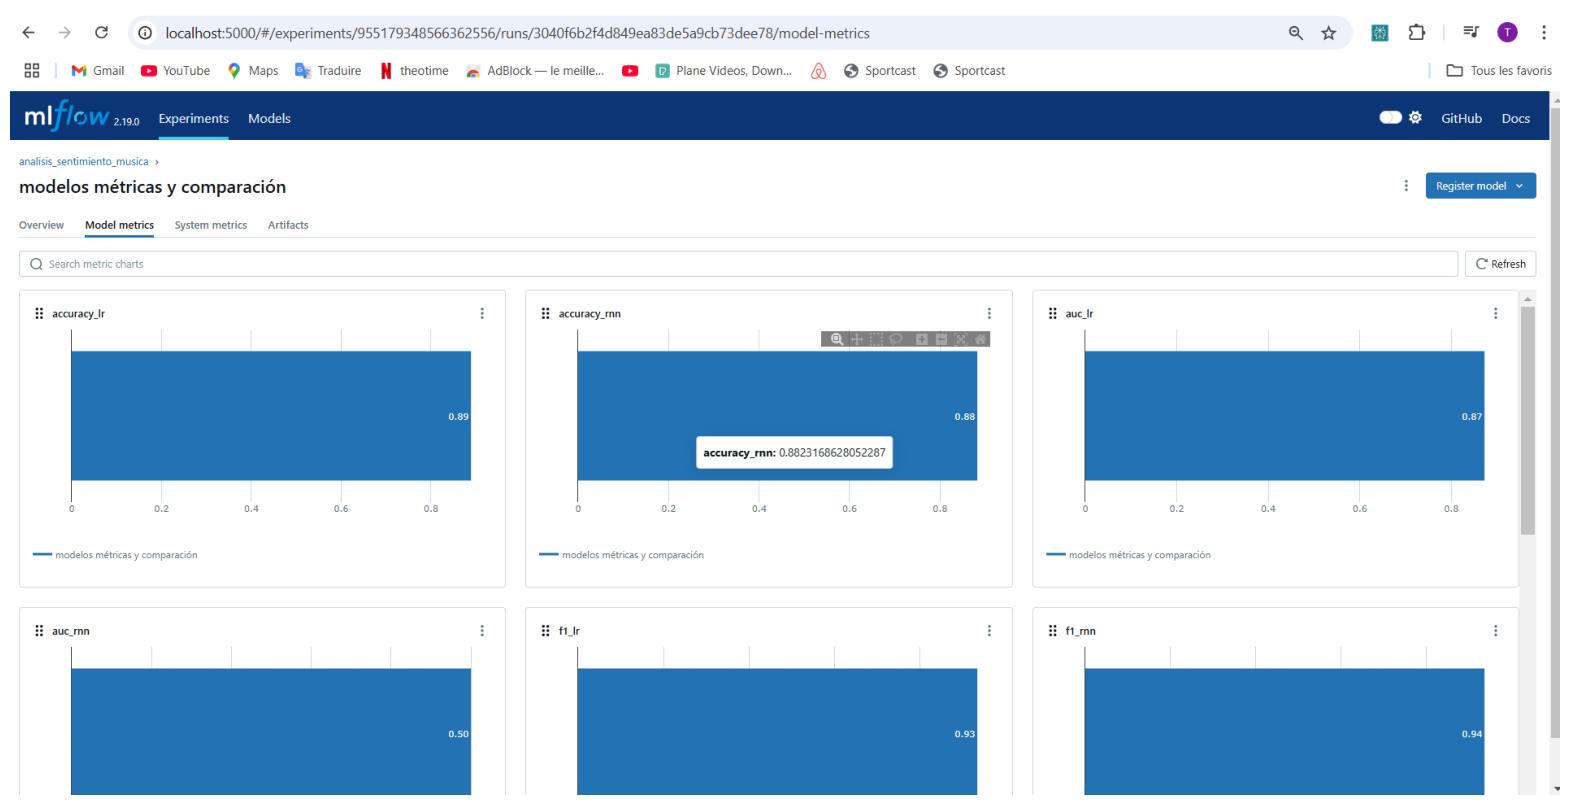

In [59]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image6.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

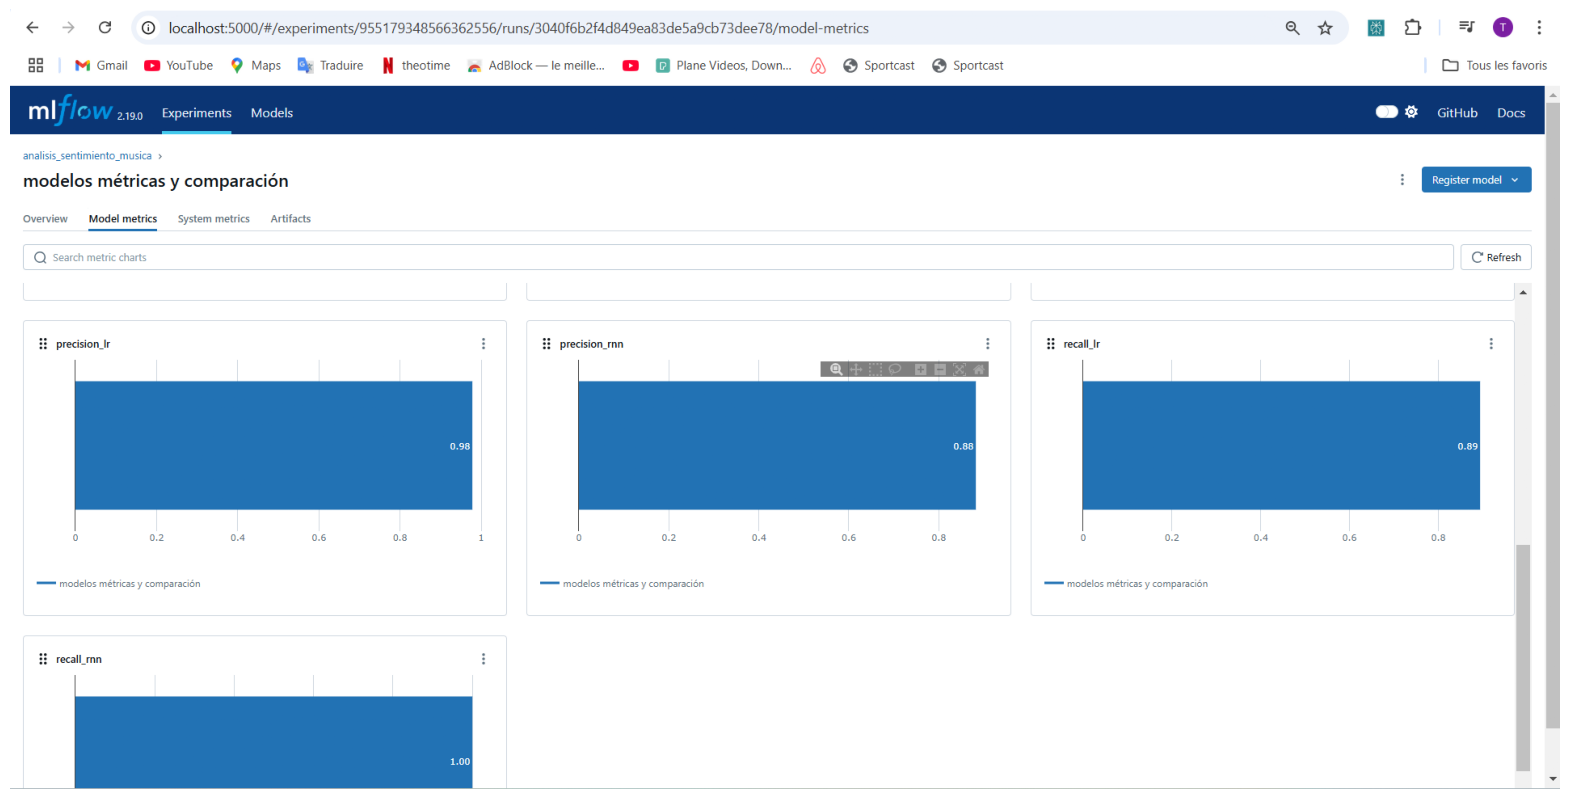

In [60]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image7.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()